# Experiments

## 0.

In [1]:
import nbimporter
from tensors import *

import numpy as np
import matplotlib.pyplot as plt
from time import time
import sklearn.decomposition
from PIL import Image
import skimage.io
import scipy.io as spio
import networkx as nx
import skimage.io

from HSI2RGB import HSI2RGB
import warnings

# import matplotlib_inline
# %matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [31]:
%%bash
lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               142
Model name:          Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
Stepping:            10
CPU MHz:             2207.999
BogoMIPS:            4415.99
Virtualization:      VT-x
Hypervisor vendor:   Microsoft
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            4096K
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp tpr_sh

In [2]:
def myHOSVD2(tensor, ranks, svdr, iters_num=100, left=0, right=None, info=None): # alternating projections
    if info is not None:
        info.init(svdr.get_svdr_name(), svdr.get_params(), l=left, r=right)
    for i in range(iters_num):
        U_list = []
        S = tensor.copy()
        S_neg = S.copy()
        S_neg[S_neg > 0] = 0
        S = np.abs(S)
        for k in range(len(tensor.shape)):
            Sk = unfold(S, k)
            Ur, Vhr = svdr(Sk, ranks[k])
            shape = list(S.shape)
            shape[k] = ranks[k]
            S = fold(Vhr, k, shape)
            U_list.append(Ur)
        tensor = restore_tensor_hosvd(S, U_list) + S_neg
        if info is not None:
            info.update(tensor)
    return S, U_list

def myTTSVD2(tensor, ranks, svdr, iters_num=100, left=0, right=None, info=None): # alternating projections
    if info is not None:
        info.init(svdr.get_svdr_name(), svdr.get_params(), l=left, r=right)
    n = np.array(tensor.shape)
    for i in range(iters_num):
        G_list = []
        G = tensor.copy()
        G_neg = G.copy()
        G_neg[G_neg > 0] = 0
        G = np.abs(G)
        G0 = unfold(G, 0)
        Ur, Vhr = svdr(G0, ranks[0])
        G_list.append(Ur)
        for k in range(1, len(tensor.shape)-1):
            Vhr = Vhr.reshape(ranks[k-1]*n[k], np.prod(n[k+1:]))
            Ur, Vhr = svdr(Vhr, ranks[k])
            r_cur = min(ranks[k], Vhr.shape[0])
            Ur = Ur.reshape(ranks[k-1], n[k], r_cur)
            G_list.append(Ur)
        G_list.append(Vhr)
        tensor = restore_tensor_ttsvd(G_list) + G_neg
        if info is not None:
            info.update(tensor)
    return G_list

In [3]:
def plot_conv(info, title='Alg_name'):
    info_ = info.get_info()
    alg_name = info.get_name()
    plt.plot(range(1, iters_num+1), info_['chebyshev'], colors[0], label=norms[0])
    plt.plot(range(1, iters_num+1), info_['frobenius'], colors[1], label=norms[1])
    plt.plot(range(1, iters_num+1), info_['density'],   colors[2], label=norms[2])
    plt.yscale('log')
    plt.yticks(yticks)
    plt.title('$\\bf{%s, %s}$\n%s' % (title, alg_name, 'Distance to nonnegative tensors'))
    plt.legend()
    plt.grid()

def SVDR(a, ho_ranks, tt_ranks):
    algs  = [HOSVD, TTSVD]
    ranks = [ho_ranks, tt_ranks]
    restore_tensor = [restore_tensor_hosvd, restore_tensor_ttsvd]
    line = '-' * 39
    print(line)
    for i in range(2):
        alg = algs[i]
        r = ranks[i]
        rt = restore_tensor[i]
        print(alg.__name__)
        print(line)

        start = time()
        g = alg(a, r)
        end = time()
        print('%-27s | %9.5f' % ('time (s.)', end-start))

        if len(g) == 2:
            ar = rt(g[0], g[1])
        else:
            ar = rt(g)

        print('%-27s | %9.5f' % ('negative elements (fro)', np.linalg.norm(ar[ar < 0])))
        print('%-27s | %9.5f' % ('negative elements (che)', np.max(abs(ar[ar < 0]), initial=0)))
        neg_count = (ar < 0).sum()
        print('%-27s | %9.5f' % ('negative elements (density)', neg_count/(np.prod(ar.shape))))
        print('%-27s | %9.5f' % ('relative error (fro)', np.linalg.norm(a - ar)/np.linalg.norm(a)))
        print('%-27s | %9.5f' % ('relative error (che)', np.max(abs(a - ar)/ np.max(abs(a)))))
        print(line)

In [7]:
norms  = ['Chebyshev', 'Frobenius', 'Density']
colors = ['C0', 'C1', 'C2']
yticks = [10**(-x) for x in range(-3, 8, 2)]

## 2. Multidimensional Gaussian mixture

In [728]:
t0 = time()

N = 128
N1 = N
N2 = N-10
N3 = N+10
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%.2f s.' % (time() - t0))

53.81 s.


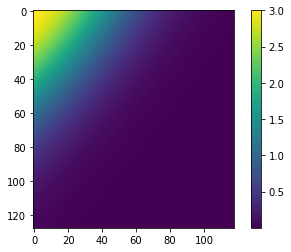

In [729]:
plt.imshow(A[:, :, 0])
plt.colorbar()

In [730]:
ho_ranks = (4, 5, 6)
tt_ranks = (4, 5)

SVDR(A, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   0.38503
negative elements (fro)     |   0.00898
negative elements (che)     |   0.00005
negative elements (density) |   0.26359
relative error (fro)        |   0.00012
relative error (che)        |   0.00056
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   0.34553
negative elements (fro)     |   0.00900
negative elements (che)     |   0.00005
negative elements (density) |   0.20467
relative error (fro)        |   0.00012
relative error (che)        |   0.00057
---------------------------------------


In [731]:
params_hosvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=100,        distr='normal',     rho=0.2),\
                dict(l=150,        distr='rademacher', rho=0.2)]
params_ttsvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='normal',     rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2)]
algs_hosvd = [Svdr(SVD)]
algs_ttsvd = [Svdr(SVD)]
for i, alg in enumerate([HMT, HMT, Tropp, GN, GN]):
    algs_hosvd.append(Svdr(alg, **params_hosvd[i]))
for i, alg in enumerate([HMT, HMT, Tropp, Tropp, GN]):
    algs_ttsvd.append(Svdr(alg, **params_ttsvd[i]))

HMT(0,70), Rad(0.2)     | 111.05 s.


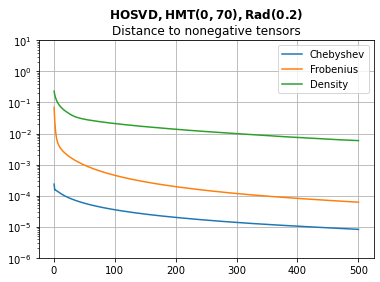

In [56]:
iters_num = 500
i = 2

mean_info = Info()
trials = 1

for _ in range(trials):
    info = Info()
    t0 = time()
    S, U_list = myHOSVD(a, ho_ranks, algs_hosvd[i], iters_num=iters_num, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))
    mean_info += info

mean_info /= trials

info_ = mean_info.get_info()
alg_name = mean_info.get_name()
plt.plot(range(1, iters_num+1), info_['chebyshev'], colors[0], label=norms[0])
plt.plot(range(1, iters_num+1), info_['frobenius'], colors[1], label=norms[1])
plt.plot(range(1, iters_num+1), info_['density'],   colors[2], label=norms[2])
plt.yscale('log')
plt.yticks(yticks)
plt.title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, 'Distance to nonnegative tensors'))
plt.legend()
plt.grid()

### 2.1 $X_i = P_r(|X_{i-1}|) + min(X_{i-1})$

In [182]:
iters_num = 150

ar_info_list_hosvd = []
ar_info_list_ttsvd = []
ar_list_hosvd = []
ar_list_ttsvd = []
    
line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    info = Info()
    t0 = time()
    S, U_list = myHOSVD2(a, ho_ranks, algs_hosvd[i], iters_num=iters_num, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))
    ar_list_hosvd.append(restore_tensor_hosvd(S, U_list))
    ar_info_list_hosvd.append(info)

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    info = Info()
    t0 = time()
    G_list = myTTSVD2(a, tt_ranks, algs_ttsvd[i], iters_num=iters_num, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
    ar_list_ttsvd.append(restore_tensor_ttsvd(G_list))
    ar_info_list_ttsvd.append(info)
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     |  66.86 s.
HMT(1,70), N(0,1)       |  42.85 s.
HMT(0,70), Rad(0.2)     |  32.73 s.
Tropp(70,100), Rad(0.2) |  34.88 s.
GN(100), N(0,1)         |   9.40 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     |  57.55 s.
HMT(1,70), N(0,1)       |  37.75 s.
HMT(0,70), Rad(0.2)     |  28.39 s.
Tropp(70,100), Rad(0.2) |  24.77 s.
GN(150), N(0,1)         |  10.95 s.
-----------------------------------


In [234]:
ar_info_list = [ar_info_list_hosvd, ar_info_list_ttsvd]
ar_list = [ar_list_hosvd, ar_list_ttsvd]
alg_names  = ['HOSVD', 'TT-SVD']
line = '-' * 73

for j in range(2):
    print(line)
    print('| %-23s | %s (fro) | %s (che) |' % (alg_names[j], 'relative error', 'relative error'))
    print(line)
    for i in range(len(ar_info_list_hosvd)):
        info = ar_info_list[j][i]
        ar = ar_list[j][i]
        fro = np.linalg.norm(a - ar) / np.linalg.norm(a)
        che = np.max(abs(a - ar)) / np.max(abs(a))
        print('| %-23s | %20.5f | %20.5f |' % (info.get_name(), fro, che))
print(line)

-------------------------------------------------------------------------
| HOSVD                   | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.00065 |              0.00162 |
| HMT(1,70), N(0,1)       |              0.00065 |              0.00162 |
| HMT(0,70), Rad(0.2)     |              0.00065 |              0.00162 |
| Tropp(70,100), Rad(0.2) |              0.00065 |              0.00162 |
| GN(100), N(0,1)         |              0.00261 |              0.00608 |
-------------------------------------------------------------------------
| TT-SVD                  | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.00529 |              0.01476 |
| HMT(1,70), N(0,1)       |              0.00529 |              0.01476 |
| HMT(0,70), Rad(0.2)     |           

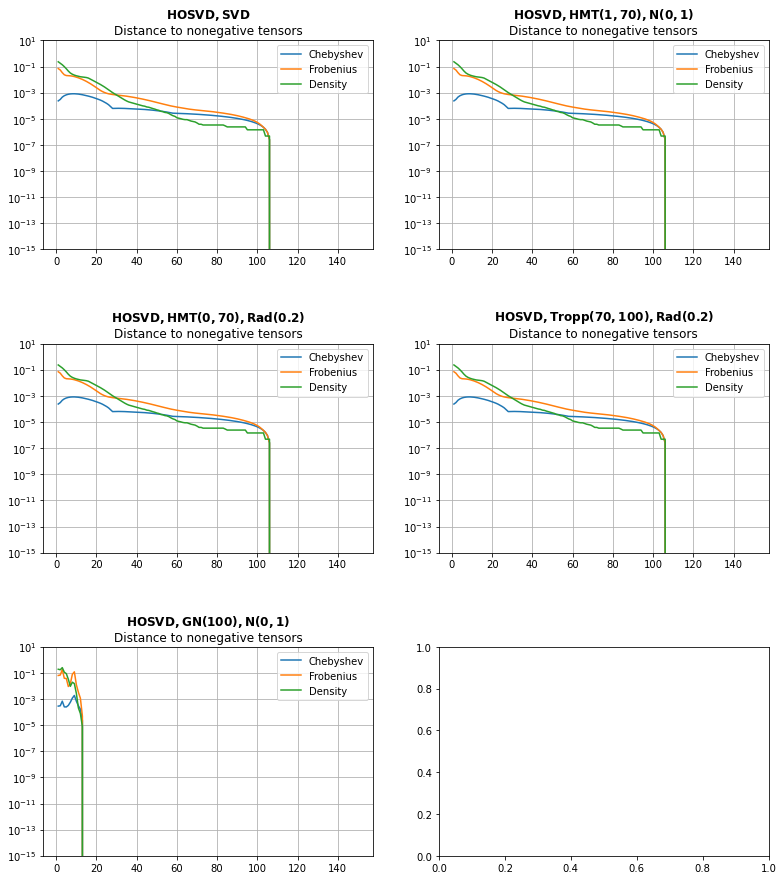

In [199]:
# HOSVD

title = 'Distance to nonnegative tensors'
info_list = ar_info_list_hosvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

In [200]:
# extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# extent.x0 -= 0.5
# extent.x1 += 5.7
# extent.y1 += 9.0
# extent.y0 -= 0.3
# fname = 'hosvd.jpg'
# fig.savefig(fname, transparent=True, bbox_inches=extent)

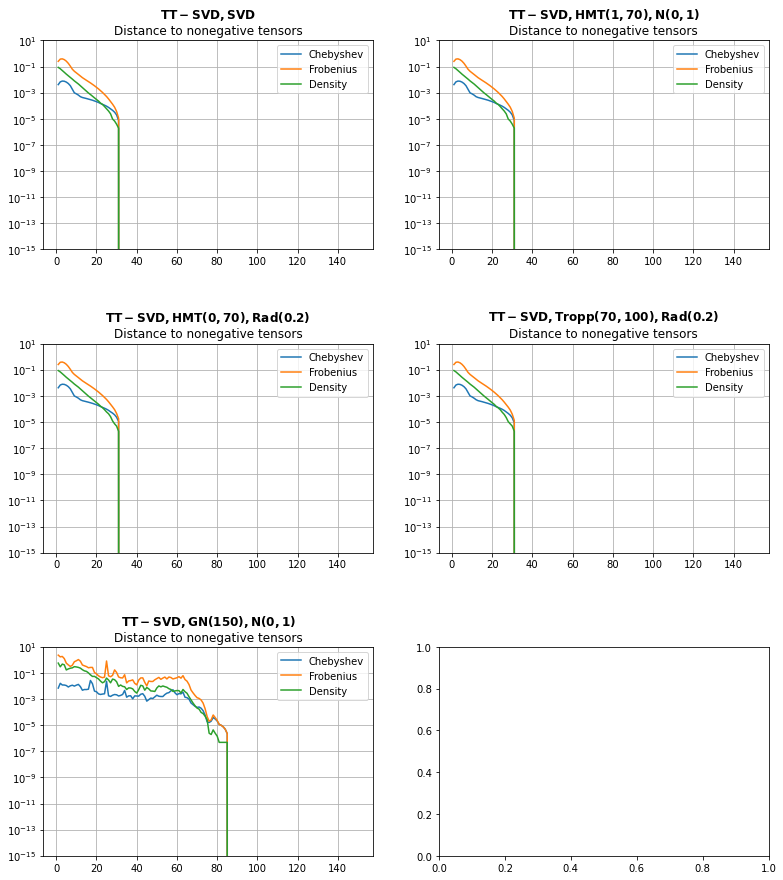

In [201]:
# TTSVD

title = 'Distance to nonnegative tensors'
info_list = ar_info_list_ttsvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('TT-SVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

In [202]:
# extent = ax[i,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# extent.x0 -= 0.5
# extent.x1 += 5.7
# extent.y1 += 9.0
# extent.y0 -= 0.3
# fname = 'ttsvd.jpg'
# fig.savefig(fname, transparent=True, bbox_inches=extent)

# 3. Stochastic cubical tensors

In [17]:
# graph generators

gilbert    = lambda n: nx.to_numpy_array(nx.binomial_graph(n, p=0.5, directed=False))
smallw     = lambda n: nx.to_numpy_array(nx.navigable_small_world_graph(int(n ** 0.5)))
geo        = lambda n: nx.to_numpy_array(nx.random_geometric_graph(n, radius=(1.44/n)**0.5, dim=2, p=2))
pref       = lambda n: nx.to_numpy_array(nx.barabasi_albert_graph(n, m=2))
rank1      = lambda n: np.ones((n, n))

# erdrey     = lambda n: nx.to_numpy_array(nx.erdos_renyi_graph(n, p=0.5, directed=True))
# lockandkey = lambda n:

g = [gilbert, smallw, geo, pref, rank1]

def get_stochatic_tensor(n, m): ## PageRank, Alg. 2
    P = np.zeros((n, n**(m-1)))
    for i in range(1, n**(m-2) + 1):
        gr = g[np.random.choice(range(len(g)))]
        P[:, (i-1)*n:i*n] = gr(n)
    col_sums = P.sum(axis=0)
    zero_cols = np.where(col_sums == 0)
    for col in zero_cols:
        row = np.random.choice(range(n))
        P[row, col] = 1
    col_sums[col_sums == 0] = 1
    P /= col_sums
    return fold(P, mode=0, shape=(n,)*m)

In [18]:
ho_ranks = [4, 5, 6]
tt_ranks = [4, 5]
a = get_stochatic_tensor(64, 3)

SVDR(a, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   0.02290
negative elements (fro)     |   1.12288
negative elements (che)     |   0.25079
negative elements (density) |   0.01075
relative error (fro)        |   0.94419
relative error (che)        |   0.98997
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   0.02002
negative elements (fro)     |   1.25337
negative elements (che)     |   0.24807
negative elements (density) |   0.01152
relative error (fro)        |   0.94033
relative error (che)        |   0.99164
---------------------------------------


In [703]:
params_hosvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=100,        distr='normal',     rho=0.2),\
                dict(l=100,        distr='rademacher', rho=0.2)]
params_ttsvd = [dict(p=1,   k=70,  distr='normal'),\
                dict(p=0,   k=70,  distr='rademacher', rho=0.2),\
                dict(k=70,  l=100, distr='rademacher', rho=0.2),\
                dict(l=150,        distr='normal',     rho=0.2),\
                dict(l=100,        distr='rademacher', rho=0.2)]
algs_hosvd = [Svdr(SVD)]
algs_ttsvd = [Svdr(SVD)]
for i, alg in enumerate([HMT, HMT, Tropp, GN]):
    algs_hosvd.append(Svdr(alg, **params_hosvd[i]))
for i, alg in enumerate([HMT, HMT, Tropp, GN]):
    algs_ttsvd.append(Svdr(alg, **params_ttsvd[i]))

In [620]:
iters_num = 2000

ar_info_list_hosvd = []
ar_info_list_ttsvd = []
ar_list_hosvd = []
ar_list_ttsvd = []
    
line = '-' * 35
print(line)
print('HOSVD')
print(line)
for i in range(len(algs_hosvd)):
    info = Info()
    t0 = time()
    S, U_list = myHOSVD(a, ho_ranks, algs_hosvd[i], iters_num=iters_num, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_hosvd[i].get_name(), t1-t0))
    ar_list_hosvd.append(restore_tensor_hosvd(S, U_list))
    ar_info_list_hosvd.append(info)

print(line)
print('TT-SVD')
print(line)
for i in range(len(algs_ttsvd)):
    info = Info()
    t0 = time()
    G_list = myTTSVD(a, tt_ranks, algs_ttsvd[i], iters_num=iters_num, info=info)
    t1 = time()
    print('%-23s | %6.2f s.' % (algs_ttsvd[i].get_name(), t1-t0))
    ar_list_ttsvd.append(restore_tensor_ttsvd(G_list))
    ar_info_list_ttsvd.append(info)
print(line)

-----------------------------------
HOSVD
-----------------------------------
SVD                     |  78.66 s.
HMT(1,70), N(0,1)       | 144.05 s.
HMT(0,70), Rad(0.2)     | 142.78 s.
Tropp(70,100), Rad(0.2) | 113.36 s.
GN(100), N(0,1)         |  28.93 s.
-----------------------------------
TT-SVD
-----------------------------------
SVD                     |  58.21 s.
HMT(1,70), N(0,1)       | 177.11 s.
HMT(0,70), Rad(0.2)     | 106.75 s.
Tropp(70,100), Rad(0.2) | 105.41 s.
GN(150), N(0,1)         |  42.18 s.
-----------------------------------


In [621]:
ar_info_list = [ar_info_list_hosvd, ar_info_list_ttsvd]
ar_list = [ar_list_hosvd, ar_list_ttsvd]
alg_names  = ['HOSVD', 'TT-SVD']
line = '-' * 73

for j in range(2):
    print(line)
    print('| %-23s | %s (fro) | %s (che) |' % (alg_names[j], 'relative error', 'relative error'))
    print(line)
    for i in range(len(ar_info_list_hosvd)):
        info = ar_info_list[j][i]
        ar = ar_list[j][i]
        fro = np.linalg.norm(a - ar) / np.linalg.norm(a)
        che = np.max(abs(a - ar)) / np.max(abs(a))
        print('| %-23s | %20.5f | %20.5f |' % (info.get_name(), fro, che))
print(line)

-------------------------------------------------------------------------
| HOSVD                   | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.94799 |              0.99136 |
| HMT(1,70), N(0,1)       |              0.94799 |              0.99136 |
| HMT(0,70), Rad(0.2)     |              0.94799 |              0.99136 |
| Tropp(70,100), Rad(0.2) |              0.94799 |              0.99136 |
| GN(100), N(0,1)         |              0.98601 |              1.00000 |
-------------------------------------------------------------------------
| TT-SVD                  | relative error (fro) | relative error (che) |
-------------------------------------------------------------------------
| SVD                     |              0.94120 |              0.99175 |
| HMT(1,70), N(0,1)       |              0.94120 |              0.99175 |
| HMT(0,70), Rad(0.2)     |           

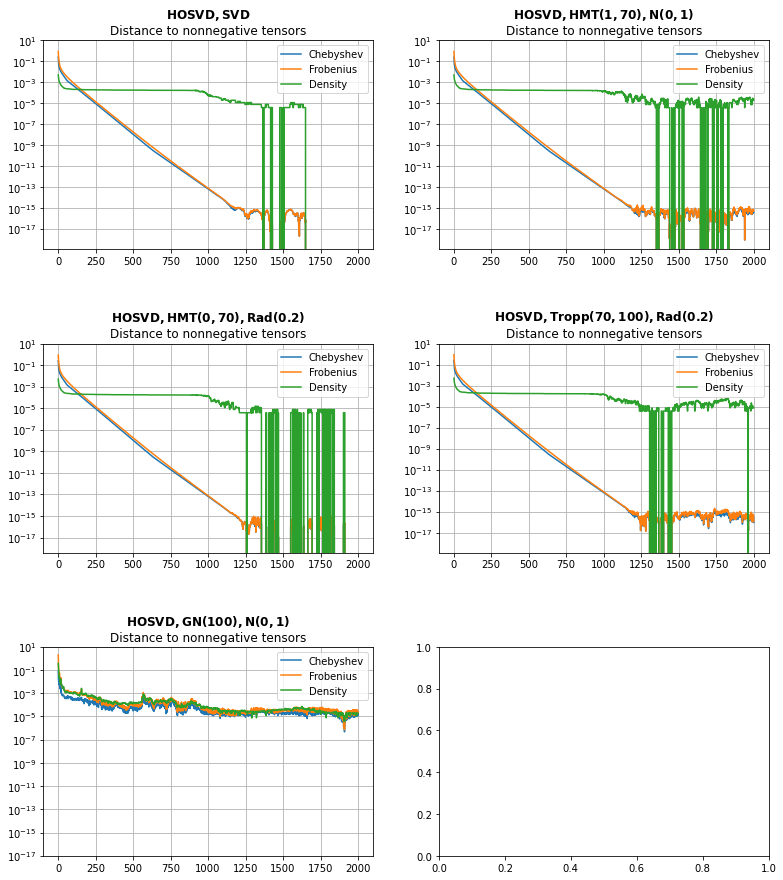

In [623]:
# HOSVD

title = 'Distance to nonnegative tensors'
info_list = ar_info_list_hosvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('HOSVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

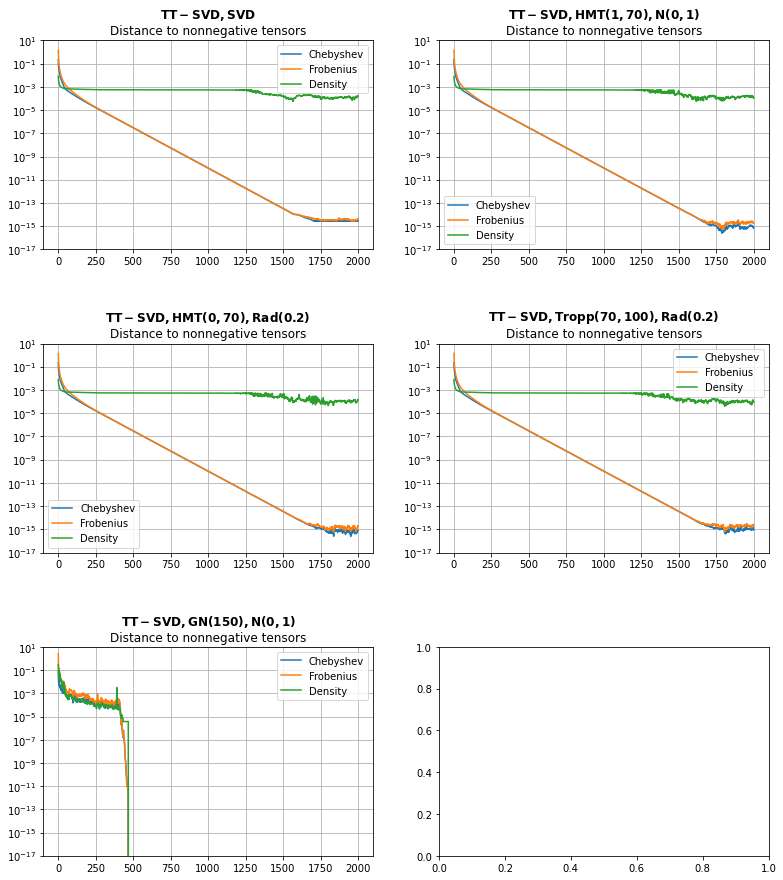

In [622]:
# TTSVD

title = 'Distance to nonnegative tensors'
info_list = ar_info_list_ttsvd
fig, ax = plt.subplots(3, 2, figsize= (13, 15))   # (13, 60)

for k in range(len(info_list)):
    info = info_list[k].get_info()
    alg_name = info_list[k].get_name()
    i = k // 2
    j = k % 2
    ax[i,j].plot(range(1, iters_num+1), info['chebyshev'], colors[0], label=norms[0])
    ax[i,j].plot(range(1, iters_num+1), info['frobenius'], colors[1], label=norms[1])
    ax[i,j].plot(range(1, iters_num+1), info['density'],   colors[2], label=norms[2])
    ax[i,j].set_yscale('log')
    ax[i,j].set_yticks(yticks)
    ax[i,j].set_title('$\\bf{%s, %s}$\n%s' % ('TT-SVD', alg_name, title))
    ax[i,j].legend()
    ax[i,j].grid()

plt.subplots_adjust(wspace=0.2, hspace=0.45)

In [14]:
r = 60 ######
ho_ranks = [r, r, r]
tt_ranks = [r, r]
a = get_stochatic_tensor(64, 3)

SVDR(a, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   0.05196
negative elements (fro)     |   3.10925
negative elements (che)     |   0.21703
negative elements (density) |   0.31722
relative error (fro)        |   0.24585
relative error (che)        |   0.48509
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   0.02841
negative elements (fro)     |   3.10925
negative elements (che)     |   0.21703
negative elements (density) |   0.31722
relative error (fro)        |   0.24585
relative error (che)        |   0.48509
---------------------------------------


In [15]:
iters_num = 200

svdr = Svdr(GN, **dict(l=100, distr='rademacher', rho=0.2))
info = Info()

t0 = time()
G_list = myTTSVD(a, tt_ranks, svdr, iters_num=iters_num, info=info)
t1 = time()
print('%-23s | %6.2f s.' % (svdr.get_name(), t1-t0))

GN(100), Rad(0.2)       |   9.04 s.


In [16]:
np.linalg.norm(restore_tensor_ttsvd(G_list) - a) / np.linalg.norm(a)

0.9579033918788392

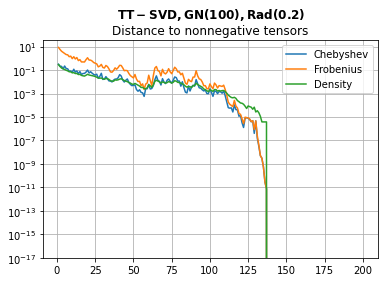

In [800]:
yticks = [10**(-x) for x in range(-1, 18, 2)]
plot_conv(info, title='TT-SVD')

### 3.1

In [801]:
def get_stochatic_tensor(shape):
    tensor = np.random.uniform(low=0.0, high=1.0, size=shape)
    mode_1 = unfold(tensor, mode=1)
    mode_1 = mode_1 / mode_1.sum(axis=0)
    return fold(mode_1, mode=1, shape=shape)

In [802]:
n = 128
shape = (n, n, n)
r = 10
ho_ranks = (r, r, r)
tt_ranks = (r, r)

a = get_stochatic_tensor(shape)

In [803]:
SVDR(a, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   0.46374
negative elements (fro)     |   0.00000
negative elements (che)     |   0.00000
negative elements (density) |   0.00000
relative error (fro)        |   0.49918
relative error (che)        |   0.57365
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   0.40266
negative elements (fro)     |   0.00000
negative elements (che)     |   0.00000
negative elements (density) |   0.00000
relative error (fro)        |   0.49721
relative error (che)        |   0.58491
---------------------------------------


## 4. Hyperspectral Image

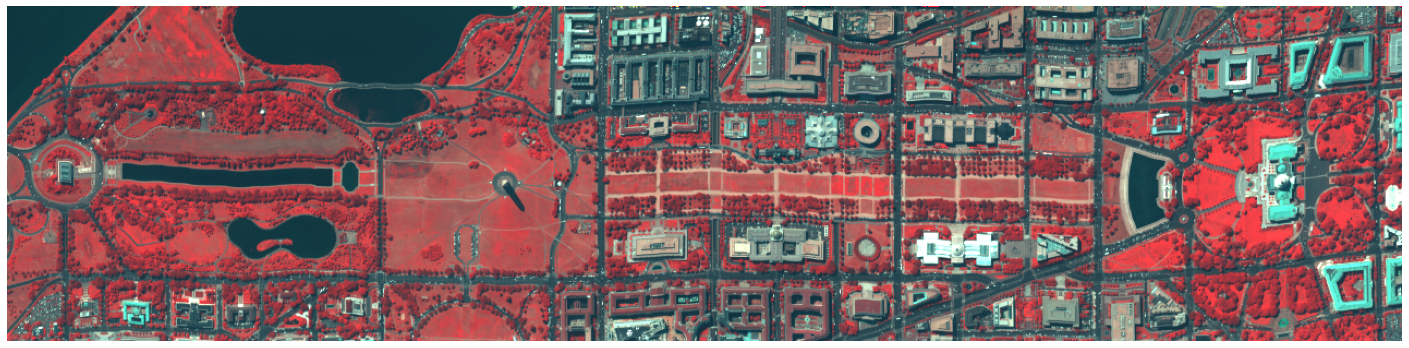

In [852]:
img = skimage.io.imread('dc.tif')
img = np.moveaxis(img, 1, 2)
# print(img.dtype, img.shape)

img = img.astype('uint16') ##

img_rgb = np.moveaxis(img[[60, 27, 17]], 0, -1)
img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
img_rgb = (img_rgb * 1500)
img_rgb = img_rgb.astype('uint16')

plt.figure(figsize=(25,25))
plt.axis('off')
plt.imshow(img_rgb)
plt.show()

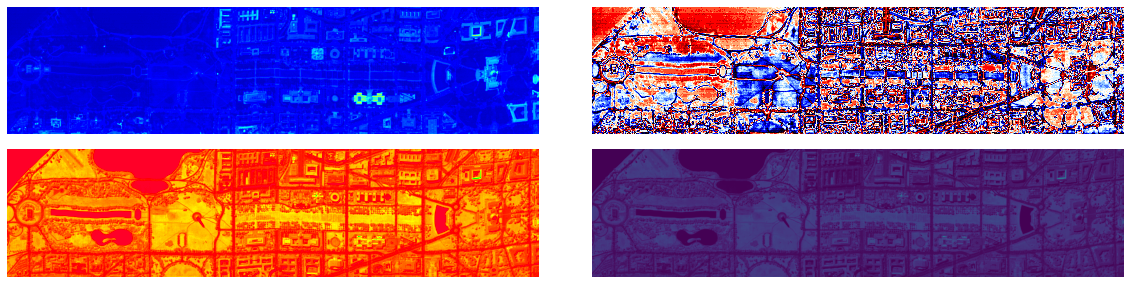

In [853]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax[0,0].imshow(img[1], cmap='jet')
ax[0,1].imshow(img[1], cmap='flag')
ax[1,0].imshow(img[100], cmap='gist_rainbow')
ax[1,1].imshow(img[100])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [854]:
img = img[:, :, 900:]
ho_ranks = [5, 5, 7]
tt_ranks = [5, 6]

img.shape

(191, 307, 380)

In [856]:
SVDR(img, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   2.66487
negative elements (fro)     | 48590.57812
negative elements (che)     | 1036.37683
negative elements (density) |   0.00849
relative error (fro)        |   0.34613
relative error (che)        |   1.00130
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   2.40869
negative elements (fro)     | 52618.42578
negative elements (che)     | 1625.32947
negative elements (density) |   0.01135
relative error (fro)        |   0.32894
relative error (che)        |   1.00216
---------------------------------------


In [855]:
iters_num = 500

svdr = Svdr(HMT, **dict(p=0,   k=70,  distr='rademacher', rho=0.2))
info = Info()


t0 = time()
G_list = myTTSVD(img, tt_ranks, svdr, iters_num=iters_num, info=info)
t1 = time()
print('%-23s | %6.2f s.' % (svdr.get_name(), t1-t0))

HMT(0,70), Rad(0.2)     | 1165.13 s.


In [864]:
imgr = restore_tensor_ttsvd(G_list)

print('TT-ranks: %s' % tt_ranks)
print('relative error (fro): %.2f' % (np.linalg.norm(img - imgr) / np.linalg.norm(img)))

TT-ranks: [5, 6]
relative error (fro): 0.33


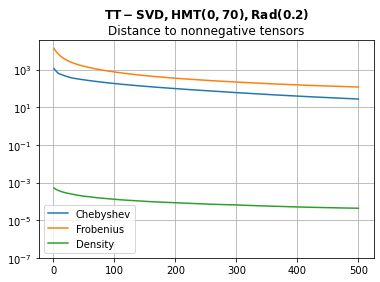

In [81]:
plot_conv(info, 'TT-SVD') ## tt_ranks=[5, 6]

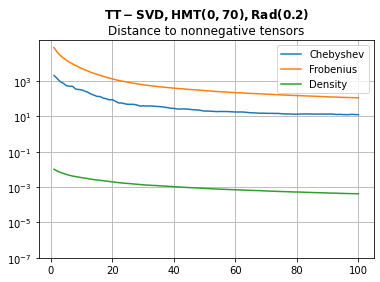

In [75]:
plot_conv(info, 'TT-SVD') ## tt_ranks=[60, 60]

$X_i = P_r(|X_{i-1}|) + min(X_{i-1})$

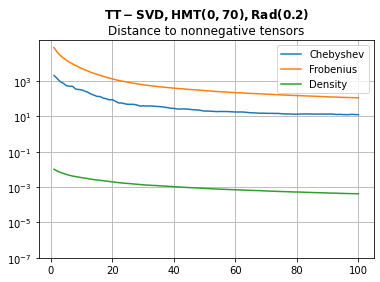

In [76]:
plot_conv(info, 'TT-SVD') ## TT-SVD v2

### 4.1 HSI 2

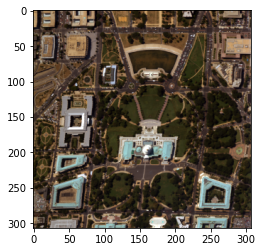

In [2]:
## https://github.com/JakobSig/HSI2RGB

HSI_path = 'data/washington_hsi.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['Y']
(ydim, xdim, zdim) = HSI_data.shape
# Load wavelengths of hyperspectral data
wl = np.squeeze(HSI_mat['wl']).tolist()

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(HSI_data, [-1,zdim])/HSI_data.max()

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.002

RGB_image = HSI2RGB(wl, HSI_data, xdim, ydim, illuminant, threshold)

plt.imshow(RGB_image)
plt.show()

shape: (191, 307, 307) | min_elem: 0.0 | max_elem: 255.0


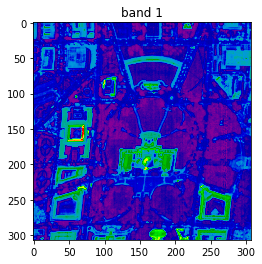

In [4]:
HSI_path = 'data/washington_hsi.mat'
HSI_mat = spio.loadmat(HSI_path)
HSI_data = HSI_mat['Y']
HSI_data = np.moveaxis(HSI_data, -1, 0)

print('shape: %s | min_elem: %.1f | max_elem: %.1f' % (HSI_data.shape, HSI_data.min(), HSI_data.max()))
plt.imshow(HSI_data[1], cmap='nipy_spectral')
plt.title(f'band {1}')
plt.show()

img = HSI_data

In [5]:
ho_ranks = [8,9,10]
tt_ranks = [10,10]

SVDR(img, ho_ranks, tt_ranks)

---------------------------------------
HOSVD
---------------------------------------
time (s.)                   |   3.91215
negative elements (fro)     | 190.49698
negative elements (che)     |  14.66274
negative elements (density) |   0.01339
relative error (fro)        |   0.30351
relative error (che)        |   0.63611
---------------------------------------
TTSVD
---------------------------------------
time (s.)                   |   2.57133
negative elements (fro)     | 405.29764
negative elements (che)     |  22.81831
negative elements (density) |   0.01954
relative error (fro)        |   0.28122
relative error (che)        |   0.69861
---------------------------------------


HMT(0,70), Rad(0.2)     | 254.02 s.
rel_err 0.28743175048776265


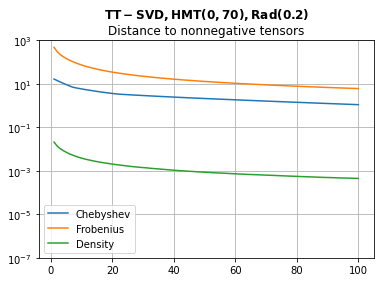

In [8]:
iters_num = 100

svdr = Svdr(HMT, **dict(p=0,   k=70,  distr='rademacher', rho=0.2))
info = Info()

t0 = time()
G_list = myTTSVD(img, tt_ranks, svdr, iters_num=iters_num, info=info)
t1 = time()
print('%-23s | %6.2f s.' % (svdr.get_name(), t1-t0))

plot_conv(info, 'TT-SVD')
imgr = restore_tensor_ttsvd(G_list)
print('rel_err', np.linalg.norm(img - imgr) / np.linalg.norm(img))

GN(150), Rad(0.2)       | 1905.23 s.
rel_err 0.39174721128388257


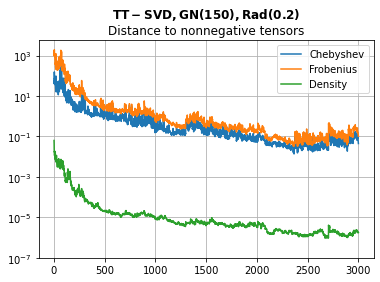

In [250]:
iters_num = 3000
svdr = Svdr(GN, **dict(l=150, distr='rademacher', rho=0.2))
info = Info()

t0 = time()
G_list = myTTSVD(img, tt_ranks, svdr, iters_num=iters_num, info=info)
t1 = time()
print('%-23s | %6.2f s.' % (svdr.get_name(), t1-t0))

yticks = [10**(-x) for x in range(-3, 8, 2)]
plot_conv(info, 'TT-SVD')
imgr = restore_tensor_ttsvd(G_list)
print('rel_err', np.linalg.norm(img - imgr) / np.linalg.norm(img))